# Prosodic Analysis for Patients with Similar BDI and PSS Trajectories

In this notebook, I wanted to explore how the trajectories for prosodic features looks like for patients who have similar BDI and PSS trajectories. I was able to identify these patients from my previous visualization work (i.e, https://github.com/DiptarkBose/Audio-Analysis/blob/master/Patient%20Recorded%20Data%20Visualization.ipynb). The patients identified for this experiment are 50049, 50063, 50083, 50086, 50098, 50099, 50100, and 50126.

Prosodic features refer to a collection of acoustic features that concern tempo-related(e.g. durational aspects, speaking rate) features. This can closely contribute to meaning and may reveal information normally not captured by textual features, such as emotional state or attitude.

The aim is to see if prosodic features show some pattern when compared against BDI and PSS values of a patient, spread across set intervals in a year.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import speech_recognition as sr
import librosa 
import librosa.display
from scipy.io import wavfile as wav
import os

In [85]:
# Set Dataframe from Excel Sheet
clinical_info_file_path = "clinical_info.xlsx"
df = pd.read_excel(clinical_info_file_path, engine="openpyxl")
num_words_spoken_dict = {50063:[262, 253, None, 237], 50126:[307, 201, 181, 377], 50100:[None, None, 215, 25]}

In [83]:
def find_prosodic_features(patient_id, fu, df_patient):
    prosodic_features = {
        "phonation_rate" : None,
        "speech_productivity" : None,
        "speech_rate" : None,
        "articulation_rate" : None
    }
    path = 'booker_audio_files/'+str(patient_id)+'/FU'+str(fu)+'.wav'
    if(os.path.isfile(path)==False):
        return prosodic_features
    audio_duration = librosa.get_duration(filename=path)
    audio_for_prosody, sample_rate = librosa.load(path, duration=audio_duration) 
    
    # Finding voiced intervals by removing silent parts of the audio
    voiced_intervals = librosa.effects.split(y=audio_for_prosody, top_db=20)
    total_voiced_duration = 0
    for interval in voiced_intervals:
        total_voiced_duration = total_voiced_duration + ((interval[1]-interval[0])/sample_rate)
    
    # To account for overflows
    if total_voiced_duration > audio_duration:
        total_voiced_duration = audio_duration
        
    total_silenced_duration = audio_duration-total_voiced_duration

    prosodic_features["phonation_rate"] = total_voiced_duration/audio_duration
    prosodic_features["speech_productivity"] = (total_silenced_duration)/total_voiced_duration 
    if fu==1:
        num_words_spoken = num_words_spoken_dict[patient_id][0]
    elif fu==3:
        num_words_spoken = num_words_spoken_dict[patient_id][1]
    elif fu==6:
        num_words_spoken = num_words_spoken_dict[patient_id][2]
    else:
        num_words_spoken = num_words_spoken_dict[patient_id][3]
    prosodic_features["speech_rate"] = num_words_spoken/audio_duration
    prosodic_features["articulation_rate"] = num_words_spoken/total_voiced_duration
    return prosodic_features

def splitSerToArr(ser):
    return [ser.index, ser.to_numpy()]

# Function for finding BDI and PSS scores from excel, finding prosodic features of audio files, and finally visualizing them together.
def visualize_patient_BDI_PSS_Prosody(patient_id):

    df_patient = df.loc[df['SID'] == patient_id]
    df_BDI = df_patient[['BDItotalscore_ED', 'BDItotalscore_1mo', 'BDItotalscore_3mo', 'BDItotalscore_6mo', 'BDItotalscore_12mo']]
    df_PSS = df_patient[['PSStotal_1month', 'PSStotal_3month', 'PSStotal_6month', 'PSStotal_12month']]
    x_axis = ["ED", "FU-1", "FU-3", "FU-6", "FU-12"]
    df_BDI = df_BDI.values.tolist()[0]
    df_PSS = df_PSS.values.tolist()[0]
    df_PSS.insert(0, None)
    df_Phonation_Rate = [None]*4
    df_Speech_Productivity = [None]*4
    df_Speech_Rate = [None]*4
    df_Articulation_Rate = [None]*4
    '''
    Prosodic feature calculation
    '''
    prosodic_features_FU1 = find_prosodic_features(patient_id, 1, df_patient)
    df_Phonation_Rate[0] = (prosodic_features_FU1["phonation_rate"])
    df_Speech_Productivity[0] = (prosodic_features_FU1["speech_productivity"])
    df_Speech_Rate[0] = (prosodic_features_FU1["speech_rate"])
    df_Articulation_Rate[0] = (prosodic_features_FU1["articulation_rate"])
    
    prosodic_features_FU3 = find_prosodic_features(patient_id, 3, df_patient)
    df_Phonation_Rate[1] = (prosodic_features_FU3["phonation_rate"])
    df_Speech_Productivity[1] = (prosodic_features_FU3["speech_productivity"])
    df_Speech_Rate[1] = (prosodic_features_FU3["speech_rate"])
    df_Articulation_Rate[1] = (prosodic_features_FU3["articulation_rate"])
    
    prosodic_features_FU6 = find_prosodic_features(patient_id, 6, df_patient)
    df_Phonation_Rate[2] = (prosodic_features_FU6["phonation_rate"])
    df_Speech_Productivity[2] = (prosodic_features_FU6["speech_productivity"])
    df_Speech_Rate[2] = (prosodic_features_FU6["speech_rate"])
    df_Articulation_Rate[2] = (prosodic_features_FU6["articulation_rate"])
    
    prosodic_features_FU12 = find_prosodic_features(patient_id, 12, df_patient)
    df_Phonation_Rate[3] = (prosodic_features_FU12["phonation_rate"])
    df_Speech_Productivity[3] = (prosodic_features_FU12["speech_productivity"])
    df_Speech_Rate[3] = (prosodic_features_FU12["speech_rate"])
    df_Articulation_Rate[3] = (prosodic_features_FU12["articulation_rate"])
    
    # Plotting graphs
    plt.plot(x_axis, df_BDI, label="BDI Scores")
    plt.plot(x_axis, df_PSS, label="PSS Scores")
    
    plt.legend()
    plt.title("BDI and PSS for Patient "+str(patient_id))
    plt.show()

    x_axis.remove("ED")
    s1 = pd.Series(df_Phonation_Rate, index=x_axis)
    s2 = pd.Series(df_Speech_Productivity, index=x_axis)
    s3 = pd.Series(df_Speech_Rate, index=x_axis)
    s4 = pd.Series(df_Articulation_Rate, index=x_axis)
    
    plt.plot( *splitSerToArr(s1.dropna()), linestyle='-', marker='o', label="Phonation Rate")
    plt.plot( *splitSerToArr(s3.dropna()), linestyle='-', marker='o', label="Speech Rate")
    plt.plot( *splitSerToArr(s4.dropna()), linestyle='-', marker='o', label="Articulation Rate")
    plt.legend()
    plt.title("Prosodic Features for Patient "+str(patient_id))
    plt.show()

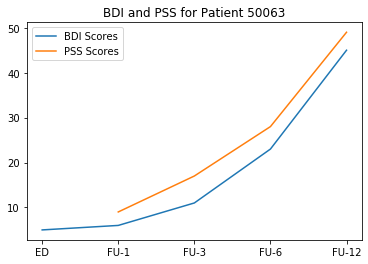

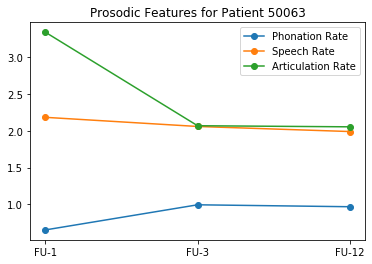

In [78]:
visualize_patient_BDI_PSS_Prosody(50063)

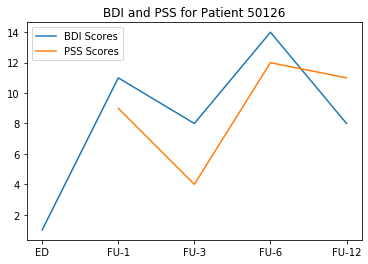

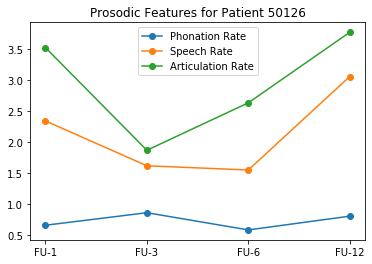

In [84]:
visualize_patient_BDI_PSS_Prosody(50126)

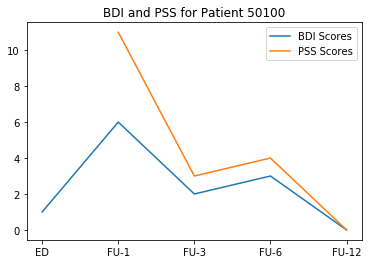

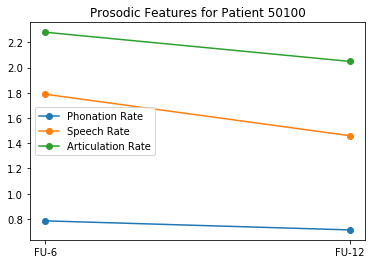

In [86]:
visualize_patient_BDI_PSS_Prosody(50100)

## Observations, Thoughts, Comments, and Questions

1. Overall observation suggested that with increasing BDI and PSS, phonation and speech rates decreased. Thus, the above examples were indicating that patients speak more when their BDI and PSS are lower.
2. Although prosodic features are showing common trends, can this be a conclusive proof? While listening to so many sessions, I realized that a patient could have been equally depressed/anxious, but could have used different ways to express their answers. For example, I can probably just say "Mmmhmm" instead of "yes", but that could mess up the speech rate statistics. 
3. In the scenario descibed above, phonation rate could be VERY useful!
4. Found a (sort of secure) way for transcribing with 2 speakers using GT's Microsoft suite. Ask Dr. Arriaga if that's a viable way to go.
5. Discuss your thoughts on Patient 50063 (ceiling collapse patient). What could be the reason for the declining condition of the patient? Is it something that can be answered via analysis? And if yes, what factors should I be focussing on?
6. Does the same set of questions make the patients bored? Have observed patients answering with proper sentences in initial sessions (which means greater number of spoken words), and then answering with "Hmm" and "Mmhmm" in later sessions (i.e, lower number of spoken words). This is something that I strongly felt while analyzing patient 50100. Although his BDI and PSS decreased, he shows lower speech and phonation rate because he answers in shorter phrases. However, observe that the phonation rate hasn't dropped as much as Speech rate, because the patient still uses sounds like "Hmm" and "Mmhmm" to answer questions.